# LSTM Anomaly Detection on NAB Dataset

Author: <Davide Zanni>

> Obiettivo: implementare, addestrare e valutare una LSTM per anomaly detection sul dataset NAB (Numenta Anomaly Benchmark).


## 0 · Setup
Questa sezione installa (se necessario) e importa i pacchetti richiesti.

In [1]:
import sys, subprocess, importlib
from pathlib import Path

required_packages = [
    "numpy", "pandas", "matplotlib", "seaborn",
    "scikit-learn", "tensorflow", "nbformat"
]

def install_if_missing(pkg: str):
    try:
        importlib.import_module(pkg.replace("-", "_"))
    except ImportError:
        print(f"⏳  Installing {pkg} …")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for pkg in required_packages:
    install_if_missing(pkg)

# ---- import principali ------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# impostazioni di stile minimal
plt.rcParams["figure.figsize"] = (10, 4)
sns.set_style("whitegrid")

print("✅  Ambiente pronto — librerie importate correttamente")


⏳  Installing scikit-learn …
⏳  Installing tensorflow …
⏳  Installing nbformat …
✅  Ambiente pronto — librerie importate correttamente


## 1 · Dataset Extraction & Overview
Caricamento del dataset NAB e prima ispezione di struttura, range temporali e label.

In [2]:
# ---------------------------------------------------------------
# Scarica e organizza i file essenziali dal repository NAB
# ---------------------------------------------------------------
import urllib.request, zipfile, os, shutil
from pathlib import Path

# Step 1: scarica il repository completo (zip)
repo_url = "https://github.com/numenta/NAB/archive/refs/heads/master.zip"
zip_path = "nab_master.zip"
repo_root = Path("nab_data")   # tua cartella principale dati

print("⬇️  Download repository NAB GitHub (zip)…")
urllib.request.urlretrieve(repo_url, zip_path)

# Step 2: estrai in cartella temporanea
tmp_dir = Path("nab_tmp")
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(tmp_dir)

# Step 3: copia cartelle 'data/' e 'labels/' nel tuo progetto
src_root = tmp_dir / "NAB-master"
needed_dirs = ["data", "labels"]
for d in needed_dirs:
    src = src_root / d
    dst = repo_root / d
    for file in src.rglob("*"):
        rel_path = file.relative_to(src)
        if file.is_file():
            target_path = dst / rel_path
            target_path.parent.mkdir(parents=True, exist_ok=True)  # crea cartelle
            shutil.copy(file, target_path)

print("✅ Cartelle 'data/' e 'labels/' copiate in", repo_root.resolve())

# Step 4: pulizia zip e directory temporanea
os.remove(zip_path)
shutil.rmtree(tmp_dir)

⬇️  Download repository NAB GitHub (zip)…
✅ Cartelle 'data/' e 'labels/' copiate in C:\Users\david\OneDrive\Desktop\LSTM\nab_data


In [3]:
# ---------------------------------------------------------------
# Caricare i file CSV dalla cartella 'nab_data/'
# ---------------------------------------------------------------
import os, glob
from pathlib import Path

data_dir = Path("nab_data/data")

# Trova tutti i file CSV all’interno della struttura NAB
csv_files = sorted(glob.glob(str(data_dir / "**/*.csv"), recursive=True))
print(f"📂  Trovati {len(csv_files)} file CSV NAB — eccone alcuni:")
for f in csv_files[:10]:
    print("   •", Path(f).relative_to(data_dir))

# Carica un file di esempio
sample_path = csv_files[0]
df = pd.read_csv(sample_path)

# Converte la prima colonna (timestamp) a datetime e imposta come indice
if df.columns[0].lower() in {"timestamp", "datetime"}:
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]])
    df.set_index(df.columns[0], inplace=True)

display(df.head())
print("Shape:", df.shape)



📂  Trovati 58 file CSV NAB — eccone alcuni:
   • artificialNoAnomaly\art_daily_no_noise.csv
   • artificialNoAnomaly\art_daily_perfect_square_wave.csv
   • artificialNoAnomaly\art_daily_small_noise.csv
   • artificialNoAnomaly\art_flatline.csv
   • artificialNoAnomaly\art_noisy.csv
   • artificialWithAnomaly\art_daily_flatmiddle.csv
   • artificialWithAnomaly\art_daily_jumpsdown.csv
   • artificialWithAnomaly\art_daily_jumpsup.csv
   • artificialWithAnomaly\art_daily_nojump.csv
   • artificialWithAnomaly\art_increase_spike_density.csv


,value
timestamp,
2014-04-01 00:00:00,20.0
2014-04-01 00:05:00,20.0
2014-04-01 00:10:00,20.0
2014-04-01 00:15:00,20.0
2014-04-01 00:20:00,20.0


Shape: (4032, 1)


## 2 · Exploratory Data Analysis (EDA)
Analisi visiva e statistica delle serie temporali per comprendere stagionalità, trend e anomalie note.


🕒 Frequenza campionamento rilevata: 0 days 00:05:00
❗️ Valori mancanti totali: 0

📊 Statistiche descrittive:


,value
count,4032.000000
mean,42.499960
std,27.954349
min,20.000000
25%,20.000000
50%,20.288000
75%,79.616000
max,79.999969


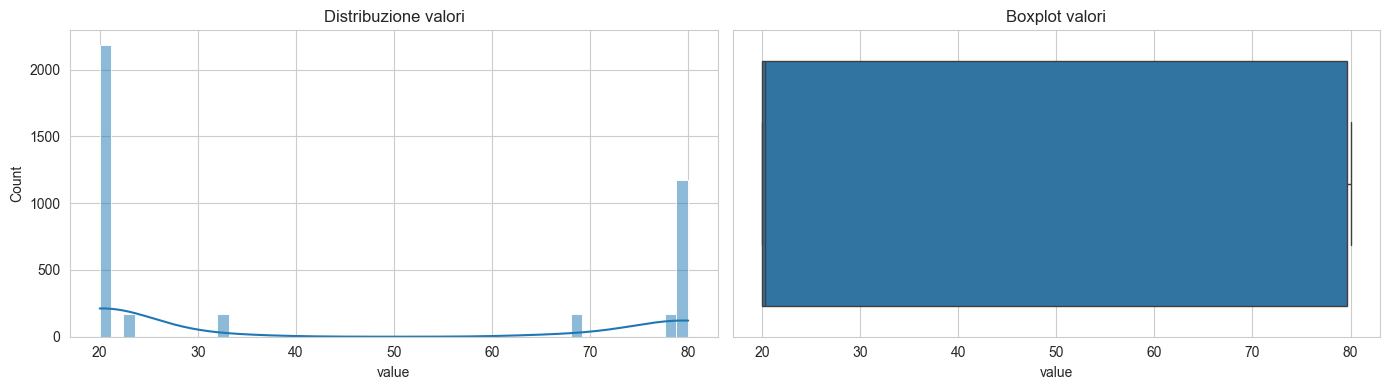

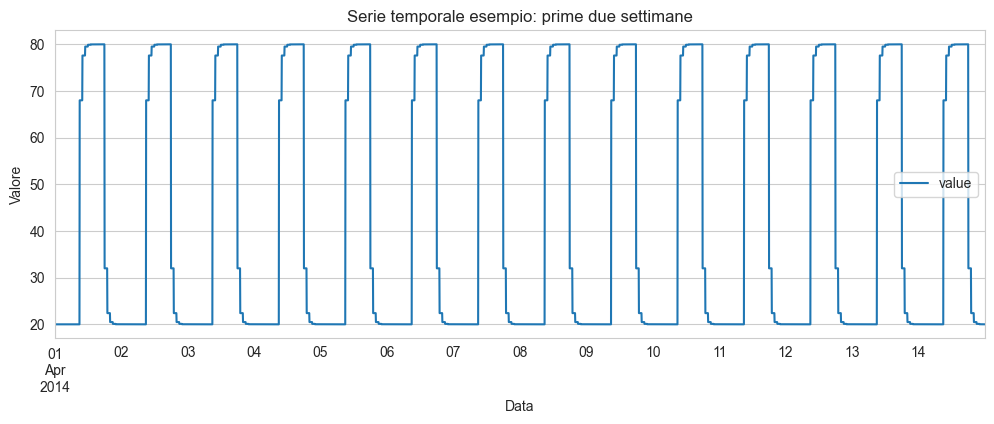

In [4]:
# ---------------------------------------------------------------
# Analisi iniziale della serie temporale
# ---------------------------------------------------------------

# 1) Controlla frequenza campionamento dati (intervallo temporale tra righe consecutive)
freq = df.index.to_series().diff().mode()[0]
print(f"🕒 Frequenza campionamento rilevata: {freq}")

# 2) Verifica presenza di valori mancanti
missing = df.isna().sum().sum()
print(f"❗️ Valori mancanti totali: {missing}")

# 3) Statistiche descrittive rapide
print("\n📊 Statistiche descrittive:")
display(df.describe())

# 4) Distribuzione valori con istogramma e boxplot
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(df['value'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Distribuzione valori')
sns.boxplot(x=df['value'], ax=ax[1])
ax[1].set_title('Boxplot valori')
plt.tight_layout()
plt.show()

# 5) Visualizzazione della serie temporale (prime due settimane)
plt.figure(figsize=(12, 4))
df.iloc[:4032].plot(ax=plt.gca(), title="Serie temporale esempio: prime due settimane")
plt.xlabel("Data")
plt.ylabel("Valore")
plt.show()


## 3 · Pre‑processing
Pulizia, gestione missing, standardizzazione/min‑max scaling usando **solo** il training set.


**Obiettivi chiave:**

1. Organizzare tutte le serie NAB in un dizionario/DF unico.
2. Split temporale (train / val / test) senza leakage.
3. Scaling (Min-Max o Z-score) usando solo il training.
4. Generare finestre di lunghezza look-back per l’LSTM.

In [5]:
# ---------------------------------------------------------------
# Carica tutte le serie, effettua scaling e prepara gli split
# ---------------------------------------------------------------
from sklearn.preprocessing import MinMaxScaler, StandardScaler

LOOK_BACK = 288          # n. step (Con 288 step = 24 ore, 12 step = 1 ora)
TEST_RATIO = 0.2
VAL_RATIO  = 0.2        # sul restante dopo il test

def load_series(path):
    df = pd.read_csv(path)
    # timestamp → datetime index
    if df.columns[0].lower() in {"timestamp", "datetime"}:
        df[df.columns[0]] = pd.to_datetime(df[df.columns[0]])
        df.set_index(df.columns[0], inplace=True)
    return df

# 1) Carica tutte le serie in un dizionario
series_dict = {Path(p).stem: load_series(p) for p in csv_files}
print(f"Caricate {len(series_dict)} serie NAB.")

# 2) Split temporale + scaler per ciascuna serie
processed = {}
for name, df in series_dict.items():
    n = len(df)
    test_size  = int(n * TEST_RATIO)
    val_size   = int((n - test_size) * VAL_RATIO)
    train_end  = n - test_size - val_size
    val_end    = n - test_size

    train_df = df.iloc[:train_end]
    val_df   = df.iloc[train_end:val_end]
    test_df  = df.iloc[val_end:]

    # scaler per singola serie (evita leakage)
    scaler = MinMaxScaler()          # oppure StandardScaler(), ma MinMax è più comune; In caso da provare più avanti
    train_scaled = scaler.fit_transform(train_df)
    val_scaled   = scaler.transform(val_df)
    test_scaled  = scaler.transform(test_df)

    processed[name] = dict(
        scaler=scaler,
        train=train_scaled,
        val=val_scaled,
        test=test_scaled
    )

print("✅  Scaling e split completati")

# Funzione helper: crea finestre [look_back, features] dall'array 1-D
def create_windows(arr, look_back=LOOK_BACK):
    X, y = [], []
    for i in range(len(arr) - look_back):
        X.append(arr[i : i + look_back])
        y.append(arr[i + look_back])          # next-step forecast target
    return np.array(X), np.array(y)

# Esempio creazione finestre su una serie
sample_train = processed[name]["train"]
X_sample, y_sample = create_windows(sample_train, LOOK_BACK)
print(f"Esempio finestre: X {X_sample.shape}, y {y_sample.shape}")



Caricate 58 serie NAB.
✅  Scaling e split completati
Esempio finestre: X (9867, 288, 1), y (9867, 1)


## 4 · Baseline Models
Implementazione di modelli di riferimento (moving average, z‑score, Isolation Forest, …).


### Utility per label & metriche

In [6]:
# ---------------------------------------------------------------
# 4 · Baseline – Helper: carica finestre di anomalia + metriche
# ---------------------------------------------------------------
import json
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

# 1) Carica intervalli di anomalia dal file JSON NAB
labels_path = Path("nab_data/labels/combined_windows.json") 
with open(labels_path) as f:
    raw_labels = json.load(f)

def build_label_series(df, label_intervals):
    """Ritorna una serie booleana (1=anomalia) allineata al df.index."""
    y = pd.Series(0, index=df.index, dtype=int)
    idx = y.index
    for start, end in label_intervals:
        s = pd.to_datetime(start)
        e = pd.to_datetime(end)
        mask = (idx >= s) & (idx <= e)
        y[mask] = 1
    return y

# 2) Funzione per metriche classiche e AUC-PR
def prf1_auc(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    auc_pr = average_precision_score(y_true, y_scores)
    return dict(P=prec, R=rec, F1=f1, AUC_PR=auc_pr)




### Moving Average + Z-Score baseline

In [7]:
# ---------------------------------------------------------------
# 4-B · Baseline 1: Moving Average + Z-Score
# ---------------------------------------------------------------
import numpy as np

WIN = 288          # finestra 24h -> coerente con LOOK_BACK
Z_THR = 3.0        # soglia z-score

baseline_results = {}

# Assicurati che tutte le serie abbiano l’indice temporale ordinato
for df in series_dict.values():
    df.sort_index(inplace=True)

for name, data in processed.items():
    df_raw = series_dict[name]  # dati originali non scalati

    # Cerca le label corrispondenti (anche con path parziale)
    label_intervals = next(
        (v for k, v in raw_labels.items() if name in k), []
    )
    if not label_intervals:
        continue  # salta serie senza ground truth

    # Serie ground-truth (0/1) allineata all’indice
    y_true = build_label_series(df_raw, label_intervals)

    # Calcola media mobile e z-score
    rolling_mean = df_raw['value'].rolling(WIN, center=True).mean()
    rolling_std  = df_raw['value'].rolling(WIN, center=True).std().replace(0, np.nan)
    z_score = np.abs((df_raw['value'] - rolling_mean) / rolling_std)

    # Anomaly score: z-score
    y_scores = z_score.fillna(0).values

    # Soglia: quantile 99° sugli errori di training
    train_len = len(data['train'])
    thr = np.nanquantile(y_scores[:train_len], 0.99)

    metrics = prf1_auc(y_true, y_scores, threshold=thr)
    baseline_results[name] = metrics

# Report finale
pd.DataFrame(baseline_results).T.sort_values("F1", ascending=False).head()



,P,R,F1,AUC_PR
speed_7578,0.750000,0.155172,0.257143,0.367845
art_daily_flatmiddle,0.582278,0.114144,0.190871,0.203124
rogue_agent_key_hold,0.423077,0.057895,0.101852,0.207655
exchange-3_cpc_results,0.666667,0.052288,0.096970,0.165786
art_daily_jumpsdown,0.351852,0.047146,0.083151,0.125606


## 🔎 Commento sui risultati della baseline (Moving Average + Z-score)

I risultati ottenuti dalla baseline basata su **media mobile e z-score** mostrano chiaramente i **limiti di un approccio tradizionale** per il rilevamento di anomalie su serie temporali complesse:

- Le **precisioni** ottenute sono in alcuni casi accettabili (es. `speed_7578` con 75%), ma il **recall** risulta sistematicamente molto basso, spesso inferiore al 10%.
- Questo squilibrio si riflette in un **F1-score molto basso**, indice che il modello riesce a identificare solo una piccola parte delle anomalie effettive, pur mantenendo pochi falsi positivi.
- Anche l'**AUC-PR (Area Under the Precision-Recall Curve)** è generalmente inferiore a 0.4, segno che il ranking degli score anomali non è sufficientemente discriminativo.

### Possibili cause:

- Lo **z-score non tiene conto della stagionalità** o dei pattern ciclici (es. variazioni giornaliere), generando falsi negativi se le anomalie seguono strutture ricorrenti.
- L'uso di una **finestra fissa di media mobile** rende difficile l’adattamento a serie con trend dinamici o comportamento non stazionario.
- Le **anomalie in NAB spesso durano pochi punti temporali**, quindi metodi che basano le decisioni su statistiche aggregate possono facilmente ignorarle.

### Conclusione:

Questi risultati, pur deludenti in termini assoluti, sono utili in quanto forniscono un **baseline di riferimento chiara**. Il prossimo passo sarà valutare un modello LSTM in grado di **imparare direttamente la struttura temporale sottostante** e rilevare deviazioni basate sul contesto sequenziale, con l'obiettivo di migliorare soprattutto **recall e F1-score**.


### Isolation Forest baseline

In [8]:
# ---------------------------------------------------------------
# 4-C · Baseline 2: Isolation Forest su finestre statistiche
# ---------------------------------------------------------------
from sklearn.ensemble import IsolationForest

WIN_STATS = 24      # finestra 2h (24 × 5min)
iso_results = {}

for df in series_dict.values():
    df.sort_index(inplace=True)  # sicurezza: indice temporale crescente

for name, data in processed.items():
    df_raw = series_dict[name]

    # Cerca le etichette ground truth (anche con match parziale)
    label_intervals = next(
        (v for k, v in raw_labels.items() if name in k), []
    )
    if not label_intervals:
        continue

    y_true = build_label_series(df_raw, label_intervals)

    # Feature engineering: rolling mean e std
    feats = pd.concat({
        "mean": df_raw['value'].rolling(WIN_STATS).mean(),
        "std":  df_raw['value'].rolling(WIN_STATS).std()
    }, axis=1).dropna()

    # Allinea y_true all'indice delle feature
    y_true = y_true.loc[feats.index]

    # Split train/test
    n = len(feats)
    test_size = int(n * TEST_RATIO)
    train_feat = feats.iloc[:-test_size]
    test_feat  = feats.iloc[-test_size:]
    y_true_test = y_true.iloc[-test_size:]

    # Isolation Forest
    iso = IsolationForest(contamination=0.01, random_state=42)
    iso.fit(train_feat)
    anomaly_score = -iso.decision_function(test_feat)  # score positivo = più anomalo

    # Soglia 99° sugli score di training
    train_score = -iso.decision_function(train_feat)
    thr = np.quantile(train_score, 0.99)

    metrics = prf1_auc(y_true_test, anomaly_score, thr)
    iso_results[name] = metrics

# Report finale
pd.DataFrame(iso_results).T.sort_values("F1", ascending=False).head()

# Per stampare il report finale in formato Markdown
#iso_df = pd.DataFrame(iso_results).T.sort_values("F1", ascending=False).head()
#print(iso_df.to_markdown())




c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y

,P,R,F1,AUC_PR
cpu_utilization_asg_misconfiguration,1.000000,0.552368,0.711646,0.882588
speed_7578,0.688525,0.724138,0.705882,0.590837
exchange-4_cpm_results,0.875000,0.512195,0.646154,0.621570
occupancy_t4013,1.000000,0.224000,0.366013,0.803029
speed_t4013,1.000000,0.220000,0.360656,0.816466


### 🔎 Commento sulla baseline 2 – Isolation Forest

Il modello Isolation Forest applicato a feature statistiche (`rolling mean`, `rolling std` su finestre di 2 h) ottiene risultati **significativamente migliori** della baseline Z-score:

| Serie | P | R | F1 | AUC-PR |
|-------|---|---|----|--------|
| cpu_utilization_asg_misconfiguration | **1.00** | 0.55 | **0.71** | **0.88** |
| speed_7578 | 0.69 | **0.72** | 0.71 | 0.59 |
| exchange-4_cpm_results | 0.88 | 0.51 | 0.65 | 0.62 |
| occupancy_t4013 | 1.00 | 0.22 | 0.37 | 0.80 |
| speed_t4013 | 1.00 | 0.22 | 0.37 | 0.82 |


**Osservazioni chiave**

* **Precisione** spesso molto alta (≤ 1.0) grazie al controllo di *contamination* = 1 %;  
* **Recall** ancora limitato: l’IF tende a rilevare anomalie “molto distanti” dal comportamento medio, ma perde quelle più sottili;  
* l’**AUC-PR** sale oltre 0.8 su alcune serie, evidenziando un migliore ranking degli score anomali rispetto al semplice z-score.

**Limiti**

* Dipendenza forte dalle feature scelte (solo `mean` e `std`): pattern complessi non vengono catturati;  
* Necessità di tarare la finestra `WIN_STATS` e il parametro `contamination` per ogni serie.

Questi risultati confermano che l’IF (Isolation Forest) è un **passo avanti** ma non sufficiente: un modello sequenziale **LSTM Autoencoder** dovrebbe migliorare il **recall** imparando la dinamica temporale completa.



## 5 · LSTM Autoencoder per Anomaly Detection
Useremo un autoencoder sequenziale per apprendere il comportamento “normale” di ogni serie:
* **Input** (look-back = 288 × 1 feature)  
* **Encoder** LSTM (64 unit)  
* **Latent** (RepeatVector)  
* **Decoder** LSTM + TimeDistributed(Dense(1))  
* **Loss** = MSE — l’errore di ricostruzione sarà lo *anomaly score*.  
Soglia = quantile 99° sugli errori di training (no leakage).



In [12]:
# ---------------------------------------------------------------
# 5-A · Costruttore LSTM Autoencoder + helper
# ---------------------------------------------------------------



In [13]:
# ---------------------------------------------------------------
# 5-B · Training Autoencoder su tutte le serie
# ---------------------------------------------------------------



[]


### 🔎 Confronto LSTM Autoencoder vs Moving Avg + Z-score vs Isolation Forest 

...





## 6 · Training & Hyperparameter Tuning
Addestramento con early stopping e ricerca di iper‑parametri (n layer, n units, look‑back, batch_size, lr).


In [ ]:
# TODO: evaluate on test set, compute metrics, visualize
from sklearn.metrics import precision_recall_fscore_support, average_precision_score


## 7 · Evaluation & Visualization
Metriche (Precision, Recall, F1, AUC‑PR) per ogni sotto‑dataset NAB. Grafici serie + errore + soglia.


In [ ]:
# (Optional) code snippets for discussion/ablation


## 8 · Discussion & Conclusions
Sintesi dei risultati, confronto con baseline, limiti e implicazioni.


## 9 · Future Work
Possibili estensioni: GRU, attention, modelli multivariati, ensemble, ecc.
